# RL4CO Quickstart Notebook

<a href="https://colab.research.google.com/github/kaist-silab/rl4co/blob/main/notebooks/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/kaist-silab/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/kaist-silab/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

In this notebooks we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should less than 2 minutes!  🚀

![Alt text](https://user-images.githubusercontent.com/48984123/245925317-0db4efdd-1c93-4991-8f09-f3c6c1f35d60.png)

### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*"../")


import torch

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

2023-07-14 23:32:01.541482: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 23:32:01.562182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:32:01.909250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Configuration

This is can be either handled by Hydra or directly passed to the `RL4COLitModule`. You may add other parameters for it as well

### Environment, Model and LitModule

In [3]:
# RL4CO env based on TorchRL
env = TSPEnv(num_loc=20) 

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       baseline='rollout',
                       train_data_size=100_000,
                       val_data_size=10_000) 
trainer = RL4COTrainer(max_epochs=3)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Test greedy rollout with untrained model and plot

Tour lengths: ['6.69', '10.23', '10.37']


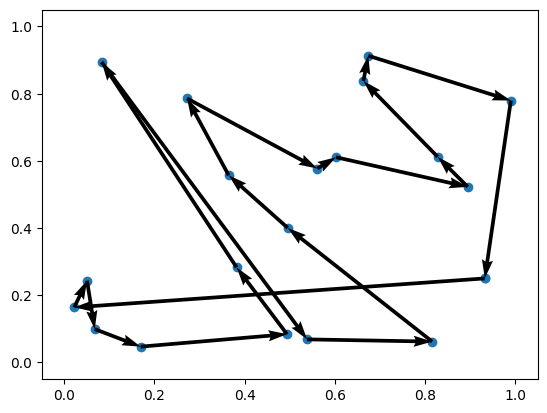

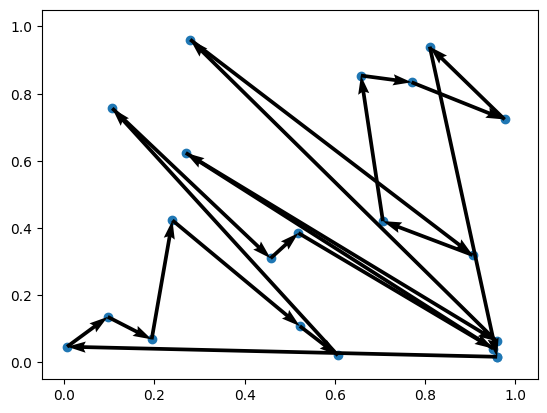

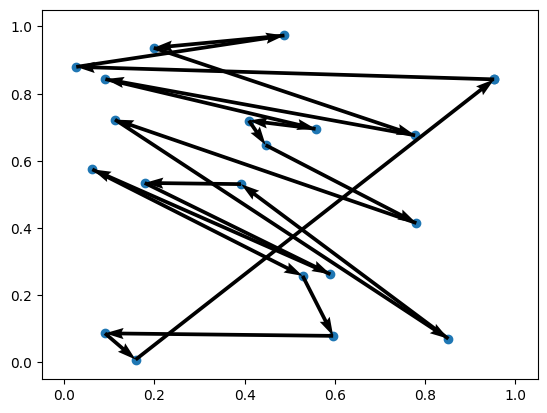

In [4]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

### Lightning Trainer

The Lightning Trainer handles the logging, checkpointing and more for you

In [5]:
model.env

TSPEnv()

In [6]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Fit the model

In [7]:
# TODO: small fix for rollot!!!!!!

trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TSPEnv               | 0     
1 | policy   | AttentionModelPolicy | 710 K 
2 | baseline | WarmupBaseline       | 710 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.fit(model)                                                                           │
│   2                                                                                              │
│                                                                                                  │
│ /home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer. │
│ py:529 in fit                                                                                    │
│                                                                                                  │
│    526 │   │   """                                                                               │
│    527 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    528 │   │   self.strategy._lightning_module = model                                           │
│ ❱  529 │   │   call._call_and_handle_interrupt(                                                  │
│    530 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    531 │   │   )                                                                                 │
│    532                                                                                           │
│                                                                                                  │
│ /home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py: │
│ 42 in _call_and_handle_interrupt                                                                 │
│                                                                                                  │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│    41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│ ❱  42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│    45 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer. │
│ py:568 in _fit_impl                                                                              │
│                                                                                                  │
│    565 │   │   │   model_provided=True,                                                          │
│    566 │   │   │   model_connected=self.lightning_module is not None,                            │
│    567 │   │   )                                                                                 │
│ ❱  568 │   │   self._run(model, ckpt_path=ckpt_path)                                             │
│    569 │   │                                                                                     │
│    570 │   │   assert self.state.stopped                                                         │
│    571 │   │   self.training = False                                                             │
│                                                                                                  │
│ /home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packag

### Testing

Tour lengths: ['4.70', '4.67', '4.83']


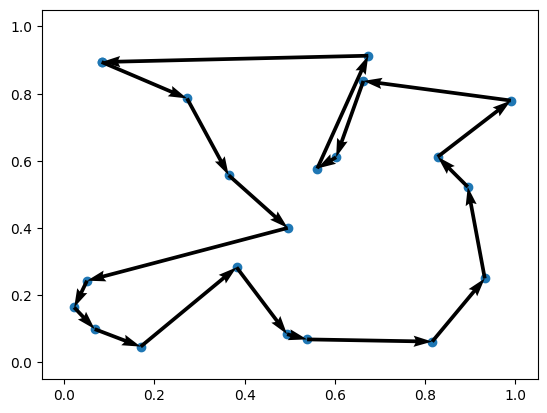

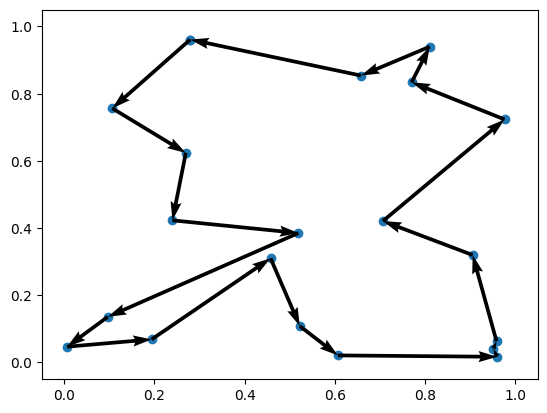

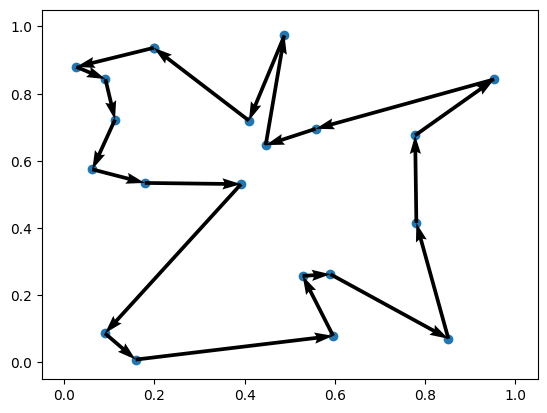

In [8]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉